In [122]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from torchvision import transforms, models
import torch.optim as optim

In [123]:
# improting the pretrained vgg network

# we only need to get the features not the classfier pparamtion
# here we are only getting the convolutional and pulling layers
vgg = models.vgg19(pretrained=True).features

In [124]:
# freezing all vgg parameters since we are only optimizing the target image

for param in vgg.parameters():
    param.requires_grad_(False)

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [126]:
# loading images

def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([transforms.Resize(size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])
    
    
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [127]:
# load in content and style images
content = load_image('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg').to(device)

style = load_image('deep-learning-v2-pytorch/style-transfer/images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [128]:
# function to un-normalize an image and convert it from tensor to numpy
# image for display

def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    
    return image

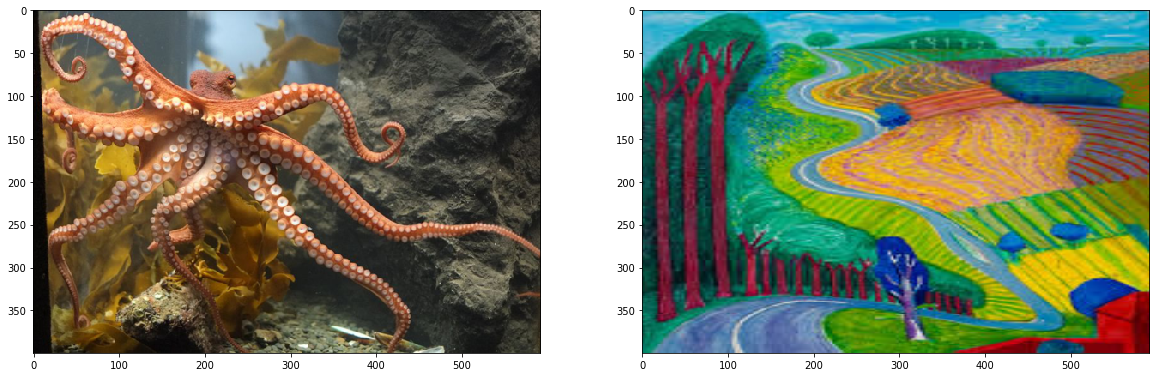

In [129]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
# complete a function to calculate the gram matrix of a given convo layer

In [130]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    
    for name, layer in model._module.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
# define the content, style, and total loss for iteratively updating
# a target image

In [ ]:
# converting a tensor image into numpy image

def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze

In [136]:
image = Image.open('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg')

In [132]:
transform = transforms.Compose([transforms.Resize(400),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

In [133]:
image = transform(image)

In [92]:
image.shape

torch.Size([3, 400, 592])

In [93]:
image = image.numpy()

In [94]:
image.shape

(3, 400, 592)

In [95]:
image = image.transpose(1,2,0)

In [96]:
image.shape

(400, 592, 3)

In [97]:
image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))

In [99]:
image.shape

(400, 592, 3)

In [100]:
image = image.clip(0,1)

In [101]:
image.shape

(400, 592, 3)

In [ ]:
plt.imshow()

In [112]:
layers = {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',
          '21': 'conv4_2',  ## content representation
          '28': 'conv5_1'}

In [114]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace=Tru

In [143]:
features = {}
x = image
x = transform(x)
x = x[:3,:,:].unsqueeze(0)

for name, layer in vgg._modules.items():
    x = layer(x)
    print(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same